In [2]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from collections import Counter
import math
import tqdm
import ast

In [2]:
#saving dict function
def save_dict(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#load dict function
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Naïve Bayes 
-----

## Multinomial Event Model

In [3]:
train = pd.read_csv('mapped_dataset.csv')  #to read

#to maintain the list format
train['mapped_text'] = train['mapped_text'].map(ast.literal_eval)
train.drop({'Unnamed: 0'},axis=1,inplace=True)

In [4]:
train.head()

,id,text,label,mapped_text
0,39545,turkey erdogan take legal action lawmaker call...,0,"[5546, 27252, 19567, 74942, 48637, 47736, 7485..."
1,23220,video watch jam keefe easily obtain eminem ele...,1,"[10203, 47551, 78336, 30152, 50169, 50613, 327..."
2,8124,believe conservative actually think scalia dea...,1,"[84778, 26772, 85709, 17914, 41905, 31481, 208..."
3,39248,philippine warn lone wolf attack marawi victor...,0,"[51781, 20570, 7185, 86395, 68827, 82657, 8395..."
4,26590,u state department question gulf motif qatar b...,0,"[40706, 45526, 10205, 41330, 86057, 47530, 657..."


In [5]:
train_0 = train.loc[train['label']==0]
train_1 = train.loc[train['label']==1]

In [6]:
word_index = load_obj('word_index')

### Parameters

In [7]:
phi_y_1 = train['label'].sum()/len(train)
phi_y_0 = 1 - phi_y_1

In [8]:
# Class priors
phi_y_1 = train['label'].sum()/len(train)
phi_y_0 = 1 - phi_y_1

# Conditionals 
n = len(word_index)

phi_0 = np.ones(n) 
phi_1 = np.ones(n)

d_0 = sum([len(i) for i in train_0.mapped_text])
d_1 = sum([len(i) for i in train_1.mapped_text])

for word, value in word_index.items():
    for tup in value:
        if tup[2] == 0:
            phi_0[word] += tup[1]
        else:
            phi_1[word] += tup[1]
            
phi_0 = phi_0/(d_0+n)
phi_1 = phi_1/(d_1+n)

In [9]:
phi_1[0:25]

array([4.20863287e-07, 4.20863287e-07, 6.31294931e-07, 4.20863287e-07,
       1.47302151e-06, 4.20863287e-07, 3.57733794e-06, 2.73561137e-06,
       4.20863287e-07, 6.31294931e-07, 4.20863287e-07, 2.33579125e-05,
       4.20863287e-07, 1.01007189e-05, 2.10431644e-07, 6.31294931e-07,
       2.10431644e-07, 4.20863287e-07, 1.89388479e-06, 2.10431644e-07,
       3.80881275e-05, 3.99820123e-06, 4.20863287e-07, 4.20863287e-07,
       4.20863287e-07])

In [10]:
phi_0[0:25]

array([2.39602968e-07, 2.39602968e-07, 2.39602968e-07, 2.39602968e-07,
       2.39602968e-07, 2.39602968e-07, 7.18808905e-07, 4.79205937e-07,
       2.39602968e-07, 2.39602968e-07, 2.39602968e-07, 2.63563265e-06,
       2.39602968e-07, 4.43265491e-05, 9.58411873e-07, 4.79205937e-07,
       9.58411873e-07, 2.39602968e-07, 2.39602968e-07, 4.79205937e-07,
       1.67722078e-06, 3.35444156e-06, 2.39602968e-07, 2.39602968e-07,
       2.39602968e-07])

### Testing

In [11]:
test = pd.read_csv('test.csv')
test.rename(columns={'Unnamed: 0': 'id'}, inplace=True) 
test.head()

,id,text,label
0,0,donald trump send embarrass new year eve messa...,1
1,4,pope francis call donald trump christmas speec...,1
2,10,papa john founder retire figure racism bad bus...,1
3,19,republican senator get drag go robert mueller ...,1
4,21,ky gop state rep commit suicide allegation mol...,1


In [12]:
vocabulary = load_obj('vocabulary')

In [13]:
def mapping_2(text):
    text = text.split()
    out = [vocabulary[word] if word in vocabulary.keys() else word for word in text]
    return out

In [14]:
test['mapped_text'] = test.text.apply(lambda x: mapping_2(x))
test.head()

,id,text,label,mapped_text
0,0,donald trump send embarrass new year eve messa...,1,"[61380, 34721, 80170, 2978, 37733, 48743, 4640..."
1,4,pope francis call donald trump christmas speec...,1,"[76017, 81750, 74858, 61380, 34721, 19301, 537..."
2,10,papa john founder retire figure racism bad bus...,1,"[27165, 70157, 21080, 53513, 78613, 7868, 4850..."
3,19,republican senator get drag go robert mueller ...,1,"[68589, 34916, 41287, 80682, 60548, 69911, 670..."
4,21,ky gop state rep commit suicide allegation mol...,1,"[10054, 28329, 45526, 12688, 80981, 88512, 822..."


In [15]:
def predict(mapped_text):
    
    phi_0_test = np.log(phi_y_0)
    phi_1_test = np.log(phi_y_1)
    
    for word in mapped_text:
        if type(word) == type('str'):
            phi_0_test += np.log(1/(d_0+n))
            phi_1_test += np.log(1/(d_1+n))
        else:
            phi_0_test += np.log(phi_0[word])
            phi_1_test += np.log(phi_1[word])
            
    if phi_0_test > phi_1_test:
        return 0
    return 1

In [16]:
test['predict'] = test.mapped_text.apply(lambda x: predict(x))

In [17]:
test.head()

,id,text,label,mapped_text,predict
0,0,donald trump send embarrass new year eve messa...,1,"[61380, 34721, 80170, 2978, 37733, 48743, 4640...",1
1,4,pope francis call donald trump christmas speec...,1,"[76017, 81750, 74858, 61380, 34721, 19301, 537...",1
2,10,papa john founder retire figure racism bad bus...,1,"[27165, 70157, 21080, 53513, 78613, 7868, 4850...",1
3,19,republican senator get drag go robert mueller ...,1,"[68589, 34916, 41287, 80682, 60548, 69911, 670...",1
4,21,ky gop state rep commit suicide allegation mol...,1,"[10054, 28329, 45526, 12688, 80981, 88512, 822...",1


In [19]:
err = round((1-(test.loc[test['label']!=test['predict']].shape[0]/test.shape[0]))*100,2)
print('Accuracy:', str(err) + '%')

Accuracy: 94.88%


### Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

In [21]:
y_true = test.label
y_predicted = test.predict
df_confusion = confusion_matrix(y_true, y_predicted)

array([[4003,  232],
       [ 228, 4517]])

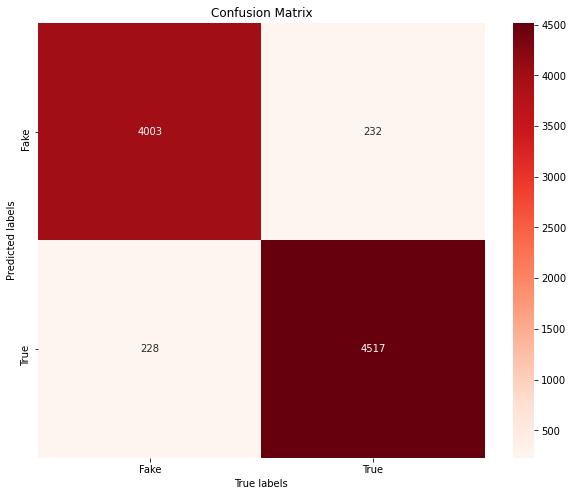

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_confusion, annot=True, fmt = 'd', ax = ax, cmap = 'Reds'); 

ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'True']); ax.yaxis.set_ticklabels(['Fake', 'True']);

## Multivariate Bernoulli

In [23]:
train = pd.read_csv('train.csv')
train.drop(columns={'Unnamed: 0': 'id'}, inplace=True) 
train.head()

,id,id,text,label
0,0,39545,turkey erdogan take legal action lawmaker call...,0
1,1,23220,video watch jam keefe easily obtain eminem ele...,1
2,2,8124,believe conservative actually think scalia dea...,1
3,3,39248,philippine warn lone wolf attack marawi victor...,0
4,4,26590,u state department question gulf motif qatar b...,0


In [24]:
test = pd.read_csv('test.csv')
test.rename(columns={'Unnamed: 0': 'id'}, inplace=True) 
test.head()

,id,text,label
0,0,donald trump send embarrass new year eve messa...,1
1,4,pope francis call donald trump christmas speec...,1
2,10,papa john founder retire figure racism bad bus...,1
3,19,republican senator get drag go robert mueller ...,1
4,21,ky gop state rep commit suicide allegation mol...,1


In [25]:
train_0 = train.loc[train['label']==0]
train_1 = train.loc[train['label']==1]

### Definition of parameters

In [26]:
phi_y_1 = train['label'].sum()/len(train)
phi_y_0 = 1 - phi_y_1

In [27]:
def zeros():
    return 0

d_1 = defaultdict(zeros)
d_0 = defaultdict(zeros)

In [28]:
def create_dict(text,d,length):
    for word in set(text.split()):
        d[word]+=1/(length + 2)

In [29]:
train_0.text.apply(lambda x: create_dict(x,d_0,len(train_0)))
phi_0 = d_0

In [30]:
train_1.text.apply(lambda x: create_dict(x,d_1,len(train_1)))
phi_1 = d_1

### Testing

In [31]:
def predict(text):
    
    phi_0_test = np.log(phi_y_0)
    phi_1_test = np.log(phi_y_1)
    

    for word in set(text.split()):
        if word in d_0.keys():
            phi_0_test += np.log(phi_0[word])
        else:
            phi_0_test += np.log(1/(len(train_0)+2))
            
        if word in d_1.keys():
            phi_1_test += np.log(phi_1[word])
        else:   
            phi_1_test += np.log(1/(len(train_1)+2)) 
                
    if phi_0_test > phi_1_test:
        return 0
    return 1

In [32]:
test['predict'] = test.text.apply(lambda x: predict(x))

In [34]:
err = round((1-(test.loc[test['label']!=test['predict']].shape[0]/test.shape[0]))*100,2)
print('Accuracy:', str(err) + '%')

Accuracy: 95.86%


### Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

In [36]:
y_true = test.label
y_predicted = test.predict
df_confusion = confusion_matrix(y_true, y_predicted)

array([[4000,  235],
       [ 137, 4608]])

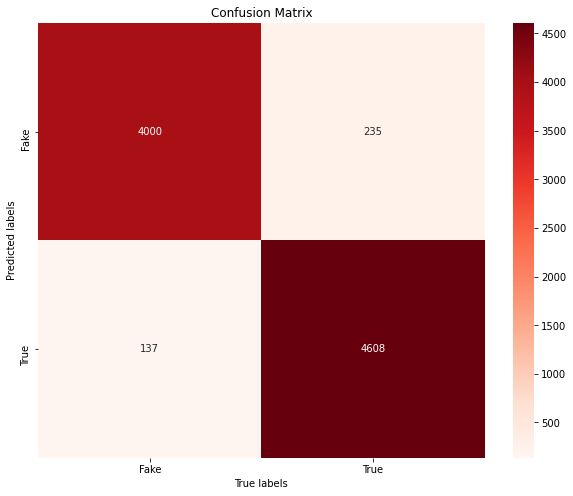

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_confusion, annot=True, fmt = 'd', ax = ax, cmap = 'Reds'); 

ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'True']); ax.yaxis.set_ticklabels(['Fake', 'True']);

## Naïve Bayes Results Analysis

In [72]:
from itertools import islice
def take(n, iterable):
    return list(islice(iterable, n))

In [71]:
fake_words = {k: v for k, v in sorted(phi_1.items(), key=lambda item: item[1], reverse=True)}
fake_300 = take(300, fake_words)

In [80]:
true_words = {k: v for k, v in sorted(phi_0.items(), key=lambda item: item[1], reverse=True)}
true_300 =take(300, true_words)

In [92]:
set_fake = set(fake_300).difference(set(true_300))
set_true = set(true_300).difference(set(fake_300))

In [ ]:
import math

In [129]:
set_true_points = {el : phi_0[el]**1/3 for el in set_true}
set_fake_points = {el : phi_1[el]**1/3 for el in set_fake}

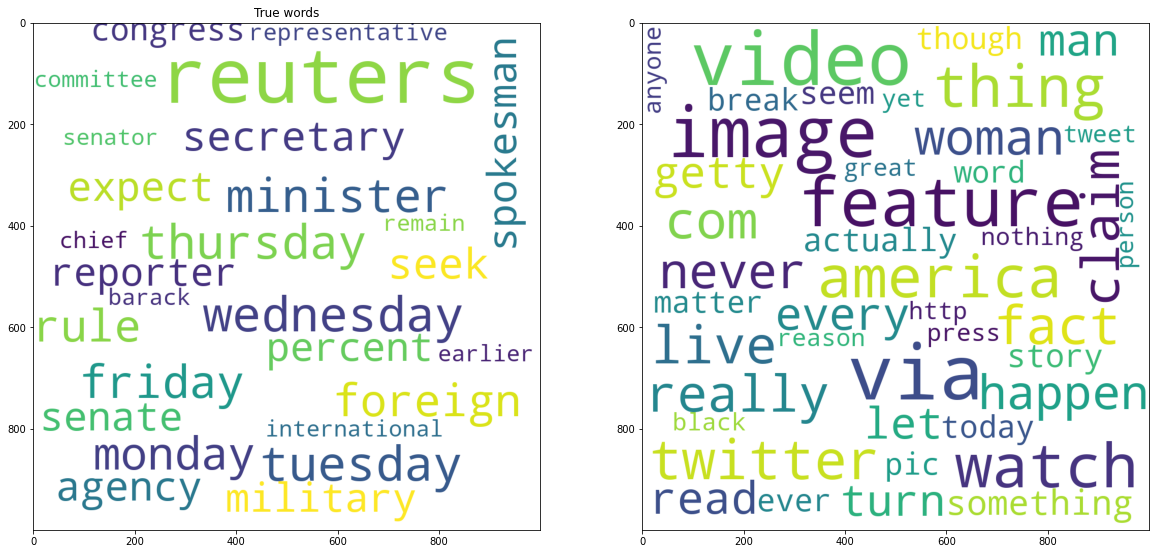

In [155]:
from PIL import Image
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,20))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.title.set_text('True words')
ax.imshow(WordCloud(background_color="white",width=1000,height=1000,min_font_size = 45, max_font_size= 150, normalize_plurals=False).generate_from_frequencies(set_true_points))
ax2.imshow(WordCloud(background_color="white",width=1000,height=1000, min_font_size =45, max_font_size= 150, normalize_plurals=False).generate_from_frequencies(set_fake_points))
plt.show()

# Decision Tree Classifier

In [3]:
train = pd.read_csv('train.csv')
train.drop({'Unnamed: 0'},axis=1,inplace=True)
train.head()

,id,text,label
0,39545,turkey erdogan take legal action lawmaker call...,0
1,23220,video watch jam keefe easily obtain eminem ele...,1
2,8124,believe conservative actually think scalia dea...,1
3,39248,philippine warn lone wolf attack marawi victor...,0
4,26590,u state department question gulf motif qatar b...,0


In [4]:
test = pd.read_csv('test.csv')
test.drop({'Unnamed: 0'},axis=1,inplace=True)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [9]:
x_train = cv.fit_transform(train['text'])
y_train = train['label']
x_test = cv.transform(test['text'])
y_test = test['label']

In [26]:
from sklearn.tree import DecisionTreeClassifier

dtc=DecisionTreeClassifier()
dtc.fit(x_train,y_train)
y_pred=dtc.predict(x_test)

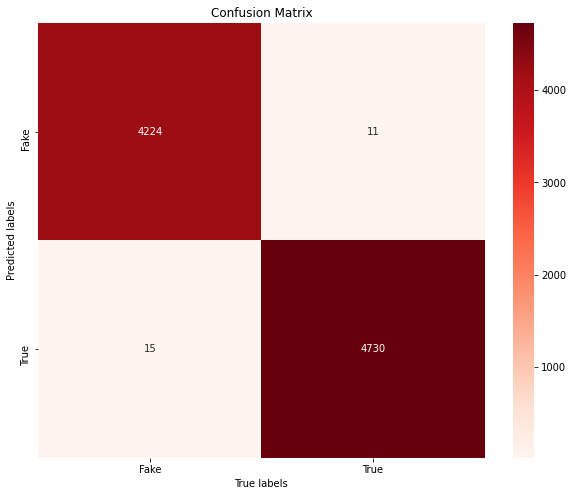

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

df_confusion = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_confusion, annot=True, fmt = 'd', ax = ax, cmap = 'Reds'); 

ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'True']); ax.yaxis.set_ticklabels(['Fake', 'True']);

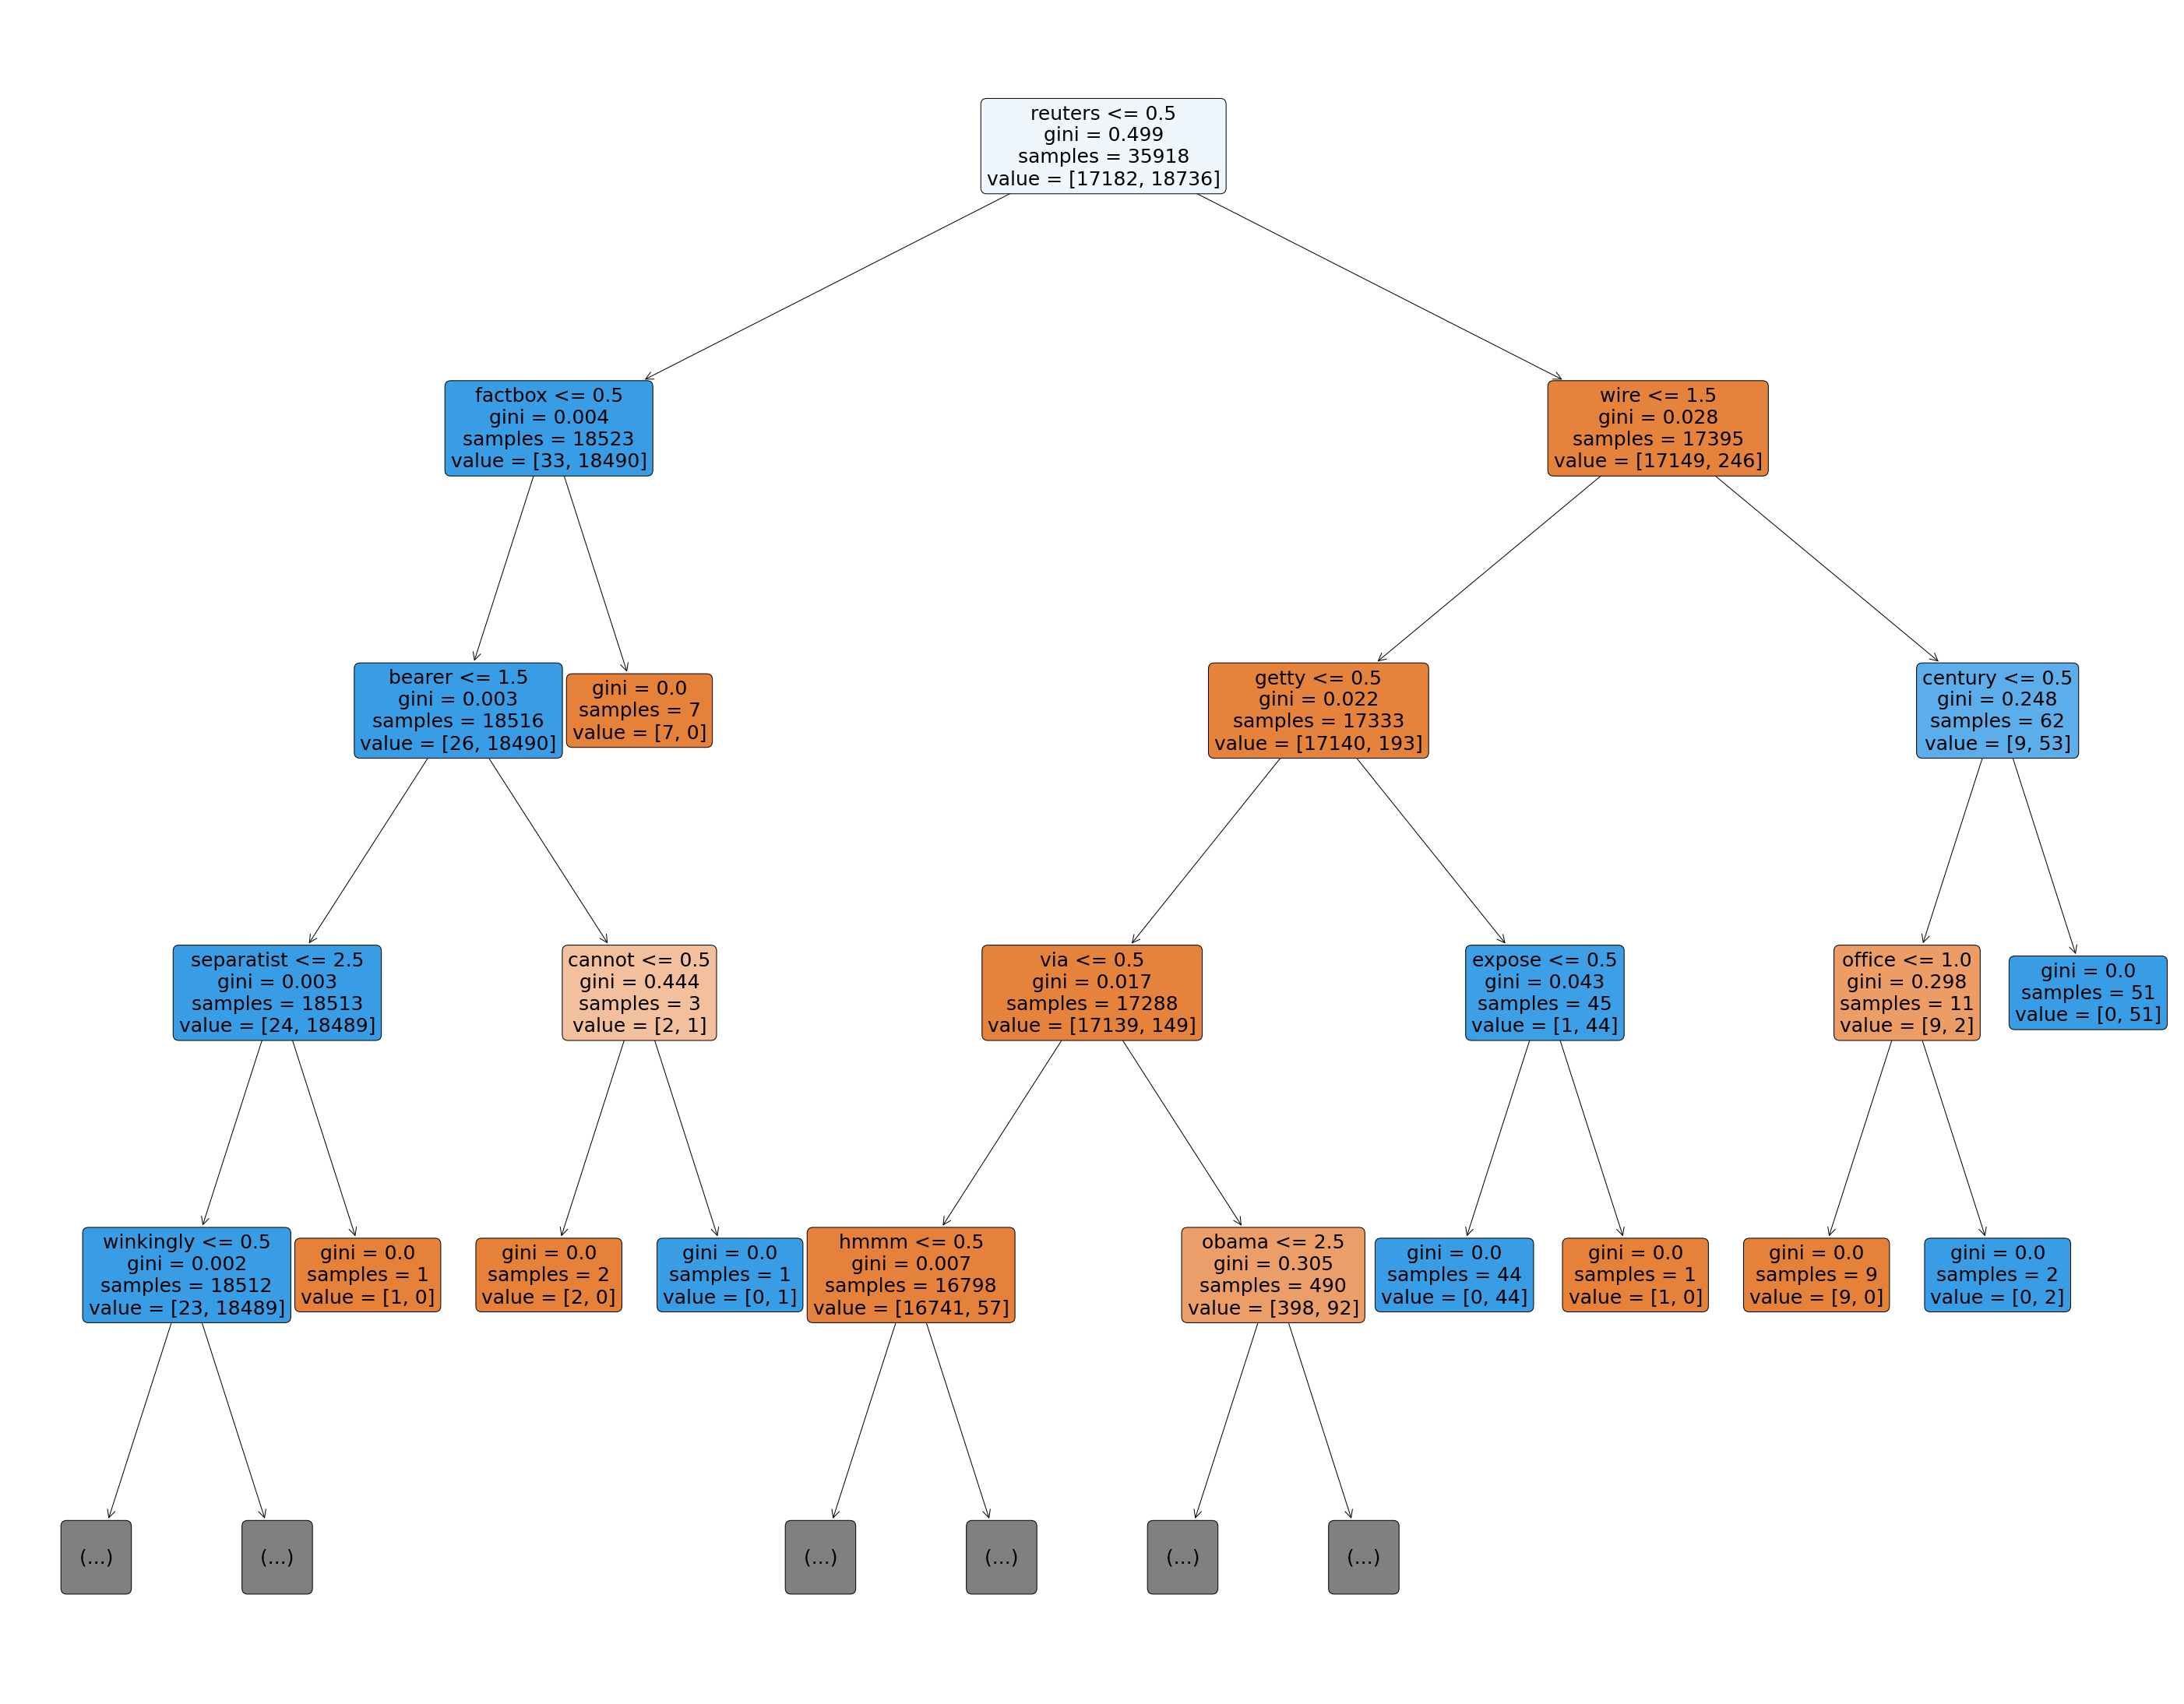

In [59]:
from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50,40))
_ = tree.plot_tree(dtc, 
                feature_names = cv.get_feature_names(),
                filled=True,
                max_depth = 4,
                fontsize= 25,
                rounded = True)